In [27]:
%run common.ipy

Using DW in /home/davo/Documents/GRASIA/daostack-notebooks/datawarehouse from date 2023-05-01T00:00:00
DW version 1.1.9
dao-analyzer version: 1.2.6
cache-scripts version: 1.1.9


In [28]:
import datetime as dt
import os, sys

# Data tools
import pandas as pd
import numpy as np
import rolling

# Visualization
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Jupyter
import ipywidgets as widgets

# Local modules
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.plot

sns.set_context('paper')

# pio.templates.default = 'seaborn' # or 'plotly_white'
pio.templates.default = 'custom_timeseries_wide'

print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.11.9 (main, May 17 2024, 13:18:38) [GCC 13.2.1 20240417]


En este notebook nos centraremos en hacer una división pre/pos 11J, y ver qué DAOs han sobrevivido y cómo

In [29]:
utils.get_dw_date()

datetime.datetime(2023, 5, 1, 0, 0)

In [30]:
import json

with open(DAOSTACK.CACHE_PATH / 'metadata.json', 'r') as f:
    metadata = json.load(f)

metadata

{'metadata': {'daostack/daos-xdai': {'block': {'number': 27714033,
    'id': '0x2b6f0eaa7fee6febf1fb0df2d67cb8cbb5bac47955f428b4fffa5568d81ad338',
    'timestamp': '2023-05-01T00:00:00+00:00'},
   'last_update': '2023-05-12T07:45:38.988078+00:00'},
  'daostack/proposals-xdai': {'block': {'number': 27714033,
    'id': '0x2b6f0eaa7fee6febf1fb0df2d67cb8cbb5bac47955f428b4fffa5568d81ad338',
    'timestamp': '2023-05-01T00:00:00+00:00'},
   'last_update': '2023-05-12T07:45:47.235052+00:00'},
  'daostack/reputationHolders-xdai': {'block': {'number': 27714033,
    'id': '0x2b6f0eaa7fee6febf1fb0df2d67cb8cbb5bac47955f428b4fffa5568d81ad338',
    'timestamp': '2023-05-01T00:00:00+00:00'},
   'last_update': '2023-05-12T07:45:53.400720+00:00'},
  'daostack/stakes-xdai': {'block': {'number': 27714033,
    'id': '0x2b6f0eaa7fee6febf1fb0df2d67cb8cbb5bac47955f428b4fffa5568d81ad338',
    'timestamp': '2023-05-01T00:00:00+00:00'},
   'last_update': '2023-05-12T07:45:57.437585+00:00'},
  'daostack/votes-xd

# Conteo de actividad

Parecido al gráfico del heatmap

In [31]:
ACTIVITY_WINDOW_SIZE = '30d'

dfa = utils.get_df('dfa')
dfa = dfa.set_index(['network', 'at']).sort_index()

dates = dfa.index.get_level_values('at')
start_date = dates.min()
end_date = dates.max()
print("End date:", end_date)

def _toapply(x):
    x = x.reset_index(level=['network']).rolling(ACTIVITY_WINDOW_SIZE)['user'].count().rename('cnt')
    x[utils.get_dw_date()] = 0
    return x

_dfgb = dfa.groupby(level='network').apply(_toapply)
fig = px.line(_dfgb.reset_index(level='network'), color='network', title='Conteo total de actividad en los últimos ' + ACTIVITY_WINDOW_SIZE)
fig

End date: 2023-04-09 11:34:47


In [32]:
fig.layout.xaxis

layout.XAxis({
    'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'at'}
})

## Por tipo de actividad

In [33]:
_dfgb = dfa.groupby(['network', 'kind']).apply(lambda x: x.reset_index(level=['network']).rolling(ACTIVITY_WINDOW_SIZE)['user'].count().rename('cnt'))
# px.line(_dfgb.reset_index(level=['network', 'kind']), y='kind', color='network')

px.line(_dfgb.reset_index().set_index('at'), y='cnt', color='network', line_dash='kind')

## Por DAO

# Conteo de usuarios ingresados con actividad

<AxesSubplot: xlabel='at'>

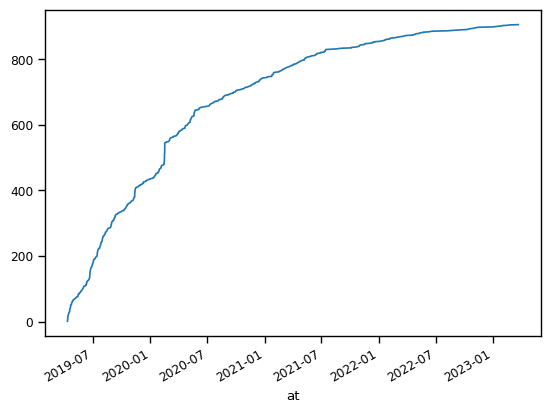

In [34]:
dfu = utils.get_df('dfa').groupby('user')['at'].min().dropna().reset_index().sort_values('at')
dfu['usercnt'] = np.arange(len(dfu))+1
dfu.set_index('at')['usercnt'].plot()

In [35]:
cut_date = '2020-05-01'
users_before = sum(dfu['at'] < cut_date)
users_total = len(dfu)
users_after = users_total - users_before

print(f'Of the {users_total} total active users, {users_before} ({users_before/users_total*100:.0f}%) joined before {cut_date}')
users_before, users_after

Of the 906 total active users, 604 (67%) joined before 2020-05-01


(604, 302)

# Nuevos usuarios (incluyendo sin actividad)

In [36]:
dfu = utils.dfAtToDatetime(pd.read_feather(DAOSTACK.REP_HOLDERS))[['network', 'address', 'createdAt', 'dao']]

# filter mainnet
dfu = dfu[dfu['network'] == 'mainnet']

dfu = dfu.groupby('address')['createdAt'].min().dropna().reset_index()

users_before = sum(dfu['createdAt'] < cut_date)
users_total = len(dfu)
users_after = users_total - users_before

print(f'Of the {users_total} total users, {users_before} ({users_before/users_total*100:.0f}%) joined before {cut_date}')
users_before, users_after

Of the 6420 total users, 6085 (95%) joined before 2020-05-01


(6085, 335)

# Conteo de usuarios activos

Un usuario activo es un usuario que ha hecho alguna actividad en los últimos `WINDOW_SIZE` días.

Básicamente, hacemos lo anterior pero contando nunique() de user

In [37]:
import numba

# Copiado de https://stackoverflow.com/q/46470743/4505998
# Hace que tarde menos de 3 años en ejecutar
@numba.jit(nopython=True)
def nunique(arr):
    return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
dfa['ucode'] = dfa['user'].cat.codes
_dfgb = dfa.groupby(level='network').apply(lambda x: x.reset_index(level=['network']).rolling(ACTIVITY_WINDOW_SIZE)['ucode'].apply(nunique, raw=True).rename('cnt'))
fig = px.line(_dfgb.reset_index(level='network'), color='network', title='Conteo de usuarios activos en los últimos ' + ACTIVITY_WINDOW_SIZE)
utils.save_fig(fig, '11J/active_users.png')

saving to ../logseq/assets/nb_figures/11J/active_users.png
Use ![Conteo de usuarios activos en los últimos 30d](../assets/nb_figures/11J/active_users.png) to embed it in logseq


In [38]:
# testing savefig
# from IPython.display import Image
# Image("../logseq/assets/nb_figures/11J/active_users.png")

## Por DAO

In [39]:
_dfa = utils.append_dao_names(dfa).reset_index(level='network', drop=True)

_dfgb = _dfa.groupby(['network', 'name']).apply(lambda x: x.rolling(ACTIVITY_WINDOW_SIZE)['ucode'].apply(nunique, raw=True).rename('cnt'))

px.line(_dfgb.reset_index().set_index('at'), y='cnt', color='name', line_dash='network')

Lo que antes parecía una batalla entre "las daos de mainnet" y "las daos de xdai", aquí vemos que es simplemente una migración. Los usuarios de dxDAO (mainnet) se han ido mudando a xDXdao (xdai) desde enero de 2021

# Número de DAOs activas

Una DAO está activa si tiene al menos un usuario activo

In [40]:
def repeat(x):
    while True:
        yield x

In [41]:
import rolling
assert rolling.__version__ >= "0.5"
from rolling.arithmetic.nunique import Nunique

_dfa = dfa[['dao']].copy().reset_index(level='network')
def _rollingNunique(s: pd.Series) -> pd.Series:
    r = Nunique(zip(s.index, s), window_size=pd.to_timedelta(ACTIVITY_WINDOW_SIZE), window_type='indexed')
    
    news = pd.Series(r, s.index, int, s.name)
    # print(s, news, "\n", sep='\n===\n')
    return news

_dfgb = _dfa.groupby(['network'], group_keys=True)['dao'].apply(_rollingNunique).rename('cnt')

def _gen_zeroes(n):
    start = _dfa[_dfa['network'] == n].index.min()
    end = utils.get_dw_date()
    
    idx = zip(repeat(n), pd.date_range(start, end))
    
    return pd.Series(0, pd.MultiIndex.from_tuples(idx))

_zeroes = pd.concat([_gen_zeroes(x) for x in _dfa['network'].unique()])
_dfgb0 = pd.concat([_dfgb, _zeroes]).sort_index()
_dfgbday = _dfgb0.groupby('network').apply(lambda x: x.droplevel(0).rolling(ACTIVITY_WINDOW_SIZE).max()).rename('cnt')

fig = px.line(_dfgbday.reset_index('network'), y='cnt', color='network', title=f'Número de DAOs con actividad en los últimos {ACTIVITY_WINDOW_SIZE}')
utils.save_fig(fig, '11J/number_active_daos.png')

saving to ../logseq/assets/nb_figures/11J/number_active_daos.png
Use ![Número de DAOs con actividad en los últimos 30d](../assets/nb_figures/11J/number_active_daos.png) to embed it in logseq


## ¿Qué DAOs en concreto eran?

In [42]:
_dfa = utils.append_dao_names(dfa).reset_index(level='network', drop=True)

# _dfgb = _dfa.groupby(['network', 'name']).apply(lambda x: x.rolling(ACTIVITY_WINDOW_SIZE)['ucode'].apply(nunique, raw=True).rename('cnt'))
_dfgb = _dfa.groupby([pd.Grouper(freq='M'), 'network', 'name']).size().rename('cnt')
_dfgb[_dfgb > 0] = 1

px.bar(_dfgb.reset_index().set_index('at'), y='cnt', color='name') #, line_dash='network')

## Número de DAOs

### Fecha primer holder

In [43]:
dfd = utils.get_df('dfd').reset_index() # .sort_values(['network', 'firstUser'])

firstDate = dfd['firstUser'].min()
ndaosHldr = dfd[['network', 'name', 'firstUser']].copy().set_index(['network', 'firstUser'])
ndaosHldr['cnt'] = 1

ndaosHldr = pd.concat([ndaosHldr, pd.DataFrame(data={
    'network': ['mainnet', 'xdai'],
    'firstUser': [utils.get_dw_date(), utils.get_dw_date()],
    'name': [ None, None ],
    'cnt': [ 0, 0 ],
}).set_index(['network', 'firstUser']), pd.DataFrame(data={
    'network': ['xdai'],
    'firstUser': [firstDate],
    'name': [None],
    'cnt': [np.NaN],
}).set_index(['network', 'firstUser'])]).sort_index()

_aux = ndaosHldr.groupby(level='network')['cnt'].cumsum().reset_index().dropna(subset='firstUser')

fig1 = px.line(_aux, color='network', x='firstUser', y='cnt', title='Número de DAOs por fecha de primer holder', line_shape='hv')
fig1

### Fecha primera actividad

In [44]:
dfd = utils.get_df('dfd').reset_index().dropna(subset=['firstActivity'])
ndaosact = dfd[['network', 'name', 'firstActivity']].copy().set_index(['network', 'firstActivity'])
ndaosact['cnt'] = 1

ndaosact = pd.concat([ndaosact, pd.DataFrame(data={
    'network': ['mainnet', 'xdai'],
    'firstUser': [utils.get_dw_date(), utils.get_dw_date()],
    'name': [ None, None ],
    'cnt': [ 0, 0 ],
}).set_index(['network', 'firstUser']), pd.DataFrame(data={
    'network': ['xdai'],
    'firstUser': [firstDate],
    'name': [None],
    'cnt': [np.NaN],
}).set_index(['network', 'firstUser'])]).sort_index()

_aux = ndaosact.groupby(level='network')['cnt'].cumsum().reset_index()
_aux['line_dash'] = 'dot'

fig2 = px.line(_aux, color='network', x='firstActivity', y='cnt', title='Número de DAOs por fecha de primera actividad')
for d in fig2.data:
    d.line['dash'] = 'dot'

fig2

In [45]:
fig = go.Figure(data=fig1.data + fig2.data, layout={
    'title': 'Número de DAOs por fecha de creación y de primera actividad',
})
utils.plot.save_fig(fig, '11J/number_daos_creation_first-activity.png')

saving to ../logseq/assets/nb_figures/11J/number_daos_creation_first-activity.png
Use ![Número de DAOs por fecha de creación y de primera actividad](../assets/nb_figures/11J/number_daos_creation_first-activity.png) to embed it in logseq


## Número  de DAOs / activas a lo largo del tiempo

Fusión de ambos gráficos

In [46]:
ACTIVITY_WINDOW_SIZE = '30d'
_dfa = dfa[['dao']].copy().reset_index(level='network')
_dfa['dao'] = _dfa['dao'].apply(int, base=16)

# display(_dfa)

_dfgb = _dfa.groupby(['network']).apply(lambda x: x.rolling(ACTIVITY_WINDOW_SIZE)['dao'].apply(nunique, raw=True).rename('cnt'))
dfact_gby =  _dfgb

figact = px.line(_dfgb.reset_index().set_index('at'), y='cnt', color='network', title=f'Número de DAOs con actividad en los últimos {ACTIVITY_WINDOW_SIZE}')

fig = go.Figure(data=figact.data+fig2.data, layout={
    'title': f'Número de DAOs (quitando inactivas) y DAOs con actividad en los últimos {ACTIVITY_WINDOW_SIZE}'
})
utils.plot.save_fig(fig, '11J/ndaos_vs_active_daos.png', show_title=True)

saving to ../logseq/assets/nb_figures/11J/ndaos_vs_active_daos.png
Use ![Número de DAOs (quitando inactivas) y DAOs con actividad en los últimos 30d](../assets/nb_figures/11J/ndaos_vs_active_daos.png) to embed it in logseq


In [47]:
utils.plot.get_network_color('mainnet', format='rgb')

'rgb(31,119,180)'

### Versión definitiva del paper

In [48]:
from plotly.subplots import make_subplots

pio.templates.default = 'seaborn'
# Hacer esto para mainnet y xdai en subplots
fig = make_subplots(rows=2, cols=1) #, row_titles=['mainnet', 'xdai'])
fig.update_layout(
    # title_text=f"Número de DAOs (quitando inactivas) y DAOs con actividad en los últimos {ACTIVITY_WINDOW_SIZE}",
    title=None,
    margin=go.layout.Margin(b=10, l=10, r=10, t=10),
    showlegend=False,
)

ndaos_gby = ndaosact.groupby(level='network')['cnt'].cumsum()

for i, n in enumerate(['mainnet', 'xdai']):
    ndaos_n = ndaos_gby.loc[n].reset_index()
    dfact_n = dfact_gby.loc[n].reset_index()
    
    # color = fig.layout['template']['layout']['template']['layout']['colorway'][i]
    color = fig.layout['template']['layout']['colorway'][i]
    
    # aux = px.line(_aux, color='network', x='firstActivity', y='cnt', title='Número de DAOs por fecha de primera actividad')

    fig.update_xaxes(
        tickmode='array',
        tickvals=pd.date_range(start=dt.date(2019, 4, 1), end=utils.plot.LAST_DATA_DATE, freq='3M'),
        tickformat='%b \'%y',
        ticks='inside',
        tickfont={'size': 14},
    )

    fig.append_trace(
        go.Scatter(
            x=ndaos_n['firstActivity'],
            y=ndaos_n['cnt'],
            line={'color': utils.plot.get_network_color(n, format='plotly'), 'dash': 'dot'},
        ),
        row=i+1, col=1,
    )
    
    fig.append_trace(
        go.Scatter(
            x=dfact_n['at'],
            y=dfact_n['cnt'],
            line={'color': utils.plot.get_network_color(n, format='plotly')},
        ),
        row=i+1, col=1,
    )

    fig.update_yaxes(
        tickfont={'size': 14},
        range=[0, 50 if n == 'xdai' else 50],
        row=i+1, col=1,
    )
    
# utils.plot.save_fig(fig, '11J/ndaos_vs_active_daos_split.png')
# fig

1433.3333333333333


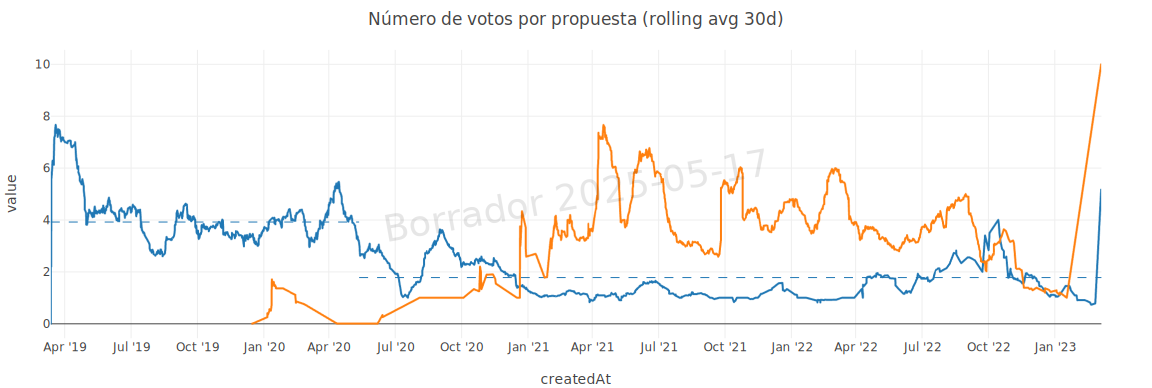

In [ ]:
from IPython.display import Image, SVG

pt_per_inch = 72
pixels_per_inch = 200

def pt_to_px(pt):
    return pt * pixels_per_inch * (1 / pt_per_inch)

print(pt_to_px(516))

for ext in ['png', 'pdf', 'svg']:
    fig.write_image(
        '../logseq/assets/nb_figures/11J/ndaos_vs_active_daos_split_final.'+ext,
        width=pt_to_px(415),
        height=pt_to_px(140),
    )
pio.templates.default = 'custom_timeseries_wide'
SVG('../logseq/assets/nb_figures/11J/ndaos_vs_active_daos_split_final.svg')

# Número de votos por propuesta (vpp)

In [50]:
dfp = utils.get_df('dfp').sort_values('createdAt')
dfp['pre11J'] = dfp['createdAt'] < '2020-06-11'
display(dfp11j := dfp.groupby(['network', 'pre11J'])['nvoters'].describe())
_aux = dfp.reset_index().set_index(['network', 'createdAt'])
_toplot = _aux.groupby('network').apply(lambda x: x.reset_index(level=['network']).rolling(ACTIVITY_WINDOW_SIZE)['nvoters'].mean())
fig = px.line(
    _toplot.reset_index(level='network'), 
    color='network',
    title=f'Número de votos por propuesta (rolling avg {ACTIVITY_WINDOW_SIZE})',
)

meanPre11J = dfp11j.loc[('mainnet', True)]['mean']
meanPos11J = dfp11j.loc[('mainnet', False)]['mean']
firstDate = dfp['createdAt'].min()
lastDate = dfp['createdAt'].max()
kwargs = {
    'mode': 'lines',
    'name': 'mainnet',
    'showlegend': False,
    'line': {
        'dash': 'dash',
        'color': fig.data[0].line.color,
        'width': 1,
    },
}

fig.add_trace(go.Scatter(
    x = [firstDate, '2020-06-11'],
    y = [meanPre11J, meanPre11J],
    **kwargs,
))

fig.add_trace(go.Scatter(
    x=['2020-06-11', lastDate],
    y=[meanPos11J, meanPos11J],
    **kwargs,
))

fig.update_layout({
        'legend': {'orientation': 'h'},
})

utils.save_fig(fig, "11J/vpp_evolution.png")

count      mean       std  min  25%  50%  75%   max
network pre11J                                                      
mainnet False    926.0  1.780778  1.792627  0.0  1.0  1.0  2.0  28.0
        True    1441.0  3.921582  3.667059  0.0  2.0  3.0  5.0  38.0
xdai    False   1450.0  4.082759  3.808754  0.0  2.0  3.0  5.0  37.0
        True     150.0  1.266667  0.902396  0.0  1.0  1.0  2.0   4.0

saving to ../logseq/assets/nb_figures/11J/vpp_evolution.png
Use ![Número de votos por propuesta (rolling avg 30d)](../assets/nb_figures/11J/vpp_evolution.png) to embed it in logseq


In [51]:
_last = dfp.sort_values('createdAt').tail()
_last[['createdAt', 'name', 'nvoters', 'title', 'description', 'votesForPct','votesAgainstPct']]

createdAt  \
network id                                                                      
mainnet 0x9db177024f122afa9bafe4df77f0750172b0d6a7abeb... 2023-03-21 01:39:59   
        0xe952937493c99ed9dc0ace38501d374059117d77af9d... 2023-03-22 18:03:35   
        0xad90760e30a7b9ebbceca714476e5e69c6817e1c1df9... 2023-03-28 09:14:11   
        0x0dc340bf6583557c718716d50d6fc8adbc6f73ab7414... 2023-04-05 13:21:11   
xdai    0x2595e6bff6eb185088b709bd1c9a7058919ca22caed6... 2023-04-05 13:25:00   

                                                             name  nvoters  \
network id                                                                   
mainnet 0x9db177024f122afa9bafe4df77f0750172b0d6a7abeb...   dxDAO        0   
        0xe952937493c99ed9dc0ace38501d374059117d77af9d...   dxDAO        0   
        0xad90760e30a7b9ebbceca714476e5e69c6817e1c1df9...   dxDAO        1   
        0x0dc340bf6583557c718716d50d6fc8adbc6f73ab7414...   dxDAO       28   
xdai    0x2595e6bff6eb185088b709bd1c9a7058919ca22caed6...  xDXdao       10   

                                                                                                       title  \
network id                                                                                                     
mainnet 0x9db177024f122afa9bafe4df77f0750172b0d6a7abeb...        CowSwap Liquidity Order e1397df1 WETH / DXD   
        0xe952937493c99ed9dc0ace38501d374059117d77af9d...                Robert's DXD Redemption Balancer #1   
        0xad90760e30a7b9ebbceca714476e5e69c6817e1c1df9...  Update swapr.eth content hash to Swapr v1.0.0-...   
        0x0dc340bf6583557c718716d50d6fc8adbc6f73ab7414...                   Register Closure Multisig Scheme   
xdai    0x2595e6bff6eb185088b709bd1c9a7058919ca22caed6...                   Register Closure Multisig Scheme   

                                                                                                 description  \
network id                                                                                                     
mainnet 0x9db177024f122afa9bafe4df77f0750172b0d6a7abeb...  This proposal places a 200 WETH order on CowSw...   
        0xe952937493c99ed9dc0ace38501d374059117d77af9d...  2611.13 DXD for 835.3 ETH and 655,795.80 USDC
...   
        0xad90760e30a7b9ebbceca714476e5e69c6817e1c1df9...  This proposal updates the swapr.eth resolver's...   
        0x0dc340bf6583557c718716d50d6fc8adbc6f73ab7414...  This proposal register the Closure Multisig as...   
xdai    0x2595e6bff6eb185088b709bd1c9a7058919ca22caed6...  This proposal register the Closure Multisig as...   

                                                          votesForPct  \
network id                                                              
mainnet 0x9db177024f122afa9bafe4df77f0750172b0d6a7abeb...         0.0   
        0xe952937493c99ed9dc0ace38501d374059117d77af9d...         0.0   
        0xad90760e30a7b9ebbceca714476e5e69c6817e1c1df9...    0.014509   
        0x0dc340bf6583557c718716d50d6fc8adbc6f73ab7414...    0.517512   
xdai    0x2595e6bff6eb185088b709bd1c9a7058919ca22caed6...    0.127861   

                                                          votesAgainstPct  
network id                                                                 
mainnet 0x9db177024f122afa9bafe4df77f0750172b0d6a7abeb...             0.0  
        0xe952937493c99ed9dc0ace38501d374059117d77af9d...             0.0  
        0xad90760e30a7b9ebbceca714476e5e69c6817e1c1df9...             0.0  
        0x0dc340bf6583557c718716d50d6fc8adbc6f73ab7414...             0.0  
xdai    0x2595e6bff6eb185088b709bd1c9a7058919ca22caed6...             0.0